In [1]:
import numpy as np
import datetime
from ga_functions import *
import matplotlib.pyplot as plt

In [3]:
params       = np.load('CL_data/parameter_test.npy')
# params = [[H0_1, ombh2_1, omch2_1], [H0_2, ombh2_2, omch2_2], ... ]
cls_unlensed = np.load('CL_data/unlensed_CL.npy')
cls_lensed   = np.load('CL_data/lensed_CL.npy')

n_data = len(params)

n_train_data = int(0.8*n_data)
n_val_data   = n_data - n_train_data

ells_factor = [ell*(ell+1) for ell in range(2,5000)]

# constructing data structure for use in ga algorithm

tot_data_points = []
for i in range(n_data):
    dat = {}
    dat["H0"] = params[i, 0]
    dat["ombh2"] = params[i, 1]
    dat["omch2"] = params[i, 2]
    dat["tau"] = 0.06
    dat["As"] = 3
    dat["cls_lensed"] = cls_lensed[i]*2*np.pi
    dat["cls_unlensed"] = cls_unlensed[i]*2*np.pi
    tot_data_points.append(dat)

train_data_points = tot_data_points[:n_train_data]
val_data_points = tot_data_points[n_train_data:]


print("Parameter Ranges:\n")

print(round(np.min(params[:, 0]), 5), " <   H0  < ",round(np.max(params[:, 0]), 5))

print(round(np.min(params[:, 1]), 5), "  < ombh2 < ",round(np.max(params[:, 1]), 5))

print(round(np.min(params[:, 2]), 5), "   < omch2 < ",round(np.max(params[:, 2]), 5))

Parameter Ranges:

50.02602  <   H0  <  89.39345
0.01505   < ombh2 <  0.02693
0.08063    < omch2 <  0.13939


In [4]:
# GA SETTINGS

config = {}

n_genes = 12 + 2 + 7 + 1
config["n_genes"] = n_genes
# n_genes is the number of constants that GA will be tuning. this is hard-coded here and in candFunction.tot_genes
# (hard-coded for now...)

# !!n_genes must be the same value as candFunction.tot_genes!!



n_pop = 100 # number of functions in the GA population
config["population"]  = n_pop
# I have not played around with how this number affects convergence/stability


config["generations"] = 100 # GA generations, 100 is usually OK... 200 to be more thorough

config["num_mutations"] = 250 # number of mutations per generation of GA
config["tournament_size"] = int(0.15*n_pop) # tournament sub-group selection... I set it at 10% of n_pop
config["batch_size"] = 50 # num of data points to use for fitness calculation

# [p_mutate_single_gene, p_mutate_multiple_genes, p_new_expression, p_do_nothing]
# probabilities associated with the above mutations^
config["mutation_probs"] = [0.65, 0.20, .05, 0.10] 
config["p_crossbreed"] = 0.01 # probability of crossbreeding
# I have not played around with how these numbers affect convergence/stability


wayne_plus_polynomial_init = [0.0396,                  -0.248,            13.6,           0.638,           1480,         -0.0606,            10.2,           0.553,           1.03,          0.0335,         -0.0473,         -0.0639,            0.5,             0.3,             0.5,             0.3,             0.5,             0.3,             0.3,             1.2,           1200,            -3.3]
wayne_plus_poly_enhanced   = [0.0396,                  -0.248,            13.6,           0.638,           1480,         -0.0606,            10.2,           0.553,           1.23,          0.0335,          0.0473,          0.0639,            0.5,             0.3,               2,             0.1,            -0.5,             0.5,             0.3,             1.2,           1200,            -3.3]


# vvvvvvvv BEST SO FAR vvvvvvv
initial_gene_vals = [ 8.21673047e-02,  3.53369396e-02,  5.04257456e+00,  4.68070264e-01,\
        1.29182108e+03,  4.60104200e-01,  1.30029558e+00, -1.08872601e-01,\
        1.27737570e+00,  2.16524787e-02,  5.94868561e-02,  1.72557661e-01,\
        3.73911112e-03,  5.52695616e-01, -2.75902847e-01, -2.13323894e-01,\
       -3.12600935e-02,  1.63422320e+01, -1.88705665e-03,  5.13091978e-02,\
        1.20924328e+03, -2.27283588e-01]
# ^^^^^^^^^^^^^^^^^^^^^^ BEST SO FAR ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


config["init_genes"] = initial_gene_vals

# initial values for GA... I used waynes values for the damping formula... 
# plus my own crude guess for alpha in the lensing fit... plus guesses for l_d and m and, -3.3 offset

config["ranges"] = np.array([[np.abs(initial_gene_vals[i])*0.10, np.abs(initial_gene_vals[i])*1.90] for i in range(n_genes)])
# I set ranges as a neighborhood around the initial GA values...
# (ranges are only used when new_expression mutation is performed... i.e. the old function is replaced with an
# entirely new function using genes randomly picked from the ranges above)

config["do_dynamic_ranges"] = True
# dynamic ranges greatly improve convergence and stability... I recommend leave set to True

ga = geneticAlgorithm(config, train_data_points)

In [5]:
RUN_GA = False
# TRUE to run new GA
# FALSE to evaluate function with your own set params

if RUN_GA:
    ga.run_algorithm()
    best = ga.best_fit_func # best_fit_func is the best GA produced result
else:
    best = candFunction()
    best.set_genes(initial_gene_vals)
    
print("\nLearned:\n")
best.genes


Learned:



[0.0821673047,
 0.0353369396,
 5.04257456,
 0.468070264,
 1291.82108,
 0.4601042,
 1.30029558,
 -0.108872601,
 1.2773757,
 0.0216524787,
 0.0594868561,
 0.172557661,
 0.00373911112,
 0.552695616,
 -0.275902847,
 -0.213323894,
 -0.0312600935,
 16.342232,
 -0.00188705665,
 0.0513091978,
 1209.24328,
 -0.227283588]

On training data...


No handles with labels found to put in legend.


Text(0, 0.5, '$C_\\ell^{TT}$')

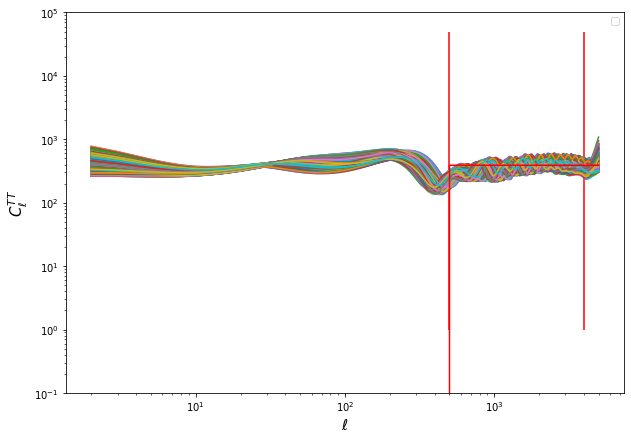

In [5]:
best2 = candFunction()
best2.set_genes(initial_gene_vals)

fig, ax = plt.subplots(figsize=(10,7))
ells = np.arange(2,5000)

params_causing_spike = []

print("On training data...")
for k in range(len(train_data_points)):
    dat = train_data_points[k]
    par = [dat["ombh2"], dat["omch2"], dat["H0"], 0.06, 1, 3]
    
    unlensed_undamped = dat["cls_lensed"]/best2.compute(par)
    
    if unlensed_undamped[-1] > 700:
        params_causing_spike.append([par[0], par[1], par[2]])
    
    ax.loglog(ells, unlensed_undamped)
    
horizontal_loss = np.array(4998*[390])
horizontal_loss[0:500] = 0
ax.loglog(ells, horizontal_loss, color="r") # red line to show loss function value

ax.vlines(500, 1, 50000, color = "r") # cutoff point... for l > cutoff the loss is calculated against the fixed value above, 50
ax.vlines(4000, 1, 50000, color = "r") # cutoff point... for l > cutoff the loss is calculated against the fixed value above, 50
ax.set_xlabel("$\ell$", fontsize=15)
ax.set_ylabel("", fontsize=15)
#ax.set_xlim(0,4500)
ax.set_ylim(10e-2,10e4)
ax.legend()
ax.set_ylabel("$C_\ell^{TT}$", fontsize=15)

On val data...


Text(0, 0.5, '$C_\\ell^{TT}$')

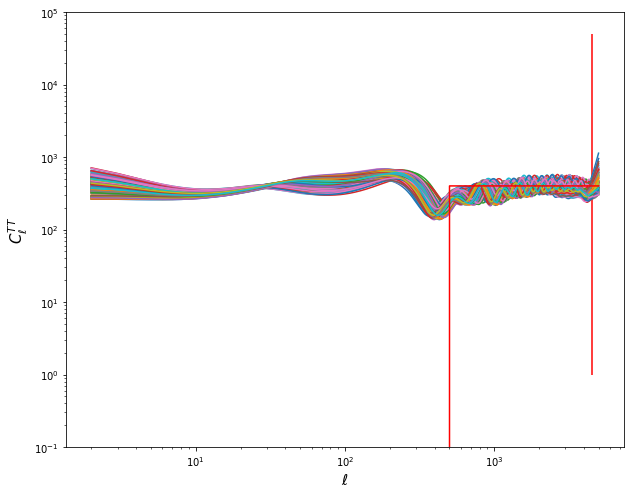

In [6]:
fig, ax = plt.subplots(figsize=(10,8))

print("On val data...")
for k in range(n_val_data):
    dat = val_data_points[k]
    par = [dat["ombh2"], dat["omch2"], dat["H0"], 0.06, 1, 3]
    unlensed_undamped = dat["cls_lensed"]/best.compute(par)
    
    if unlensed_undamped[-1] > 700:
        params_causing_spike.append([par[0], par[1], par[2]])
        
    ax.loglog(ells, unlensed_undamped)
    
    #ax.legend()
    
horizontal_loss = np.array(4998*[400])
horizontal_loss[0:500] = 0
ax.loglog(ells, horizontal_loss, color="r") # red line to show loss function value

ax.vlines(4500, 1, 50000, color = "r") # cutoff point... for l > cutoff the loss is calculated against the fixed value above, 50
ax.set_xlabel("$\ell$", fontsize=15)
ax.set_ylabel("", fontsize=15)
#ax.set_xlim(1000, 5000)
ax.set_ylim(10e-2,10e4)
ax.set_ylabel("$C_\ell^{TT}$", fontsize=15)

on all data...


Text(0, 0.5, '$C_\\ell^{TT}$')

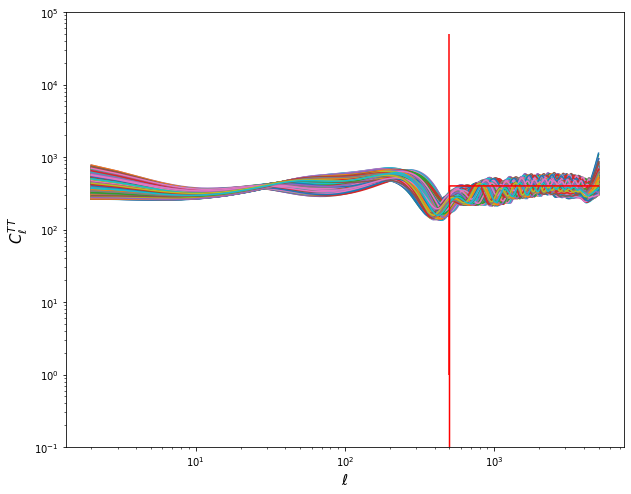

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
print("on all data...")

for k in range(n_data):
    dat = tot_data_points[k]
    par = [dat["ombh2"], dat["omch2"], dat["H0"], 0.06, 1, 3]
    
    unlensed_undamped = dat["cls_lensed"]/best.compute(par)
        
    ax.loglog(ells, unlensed_undamped)
    
    #ax.legend()
    
horizontal_loss = np.array(4998*[400])
horizontal_loss[0:500] = 0
ax.loglog(ells, horizontal_loss, color="r") # red line to show loss function value

ax.vlines(500, 1, 50000, color = "r") # cutoff point... for l > cutoff the loss is calculated against the fixed value above, 50
ax.set_xlabel("$\ell$", fontsize=15)
ax.set_ylabel("", fontsize=15)
#ax.set_xlim(1000, 5000)
ax.set_ylim(10e-2,10e4)
ax.set_ylabel("$C_\ell^{TT}$", fontsize=15)

(25.0, 114.0)

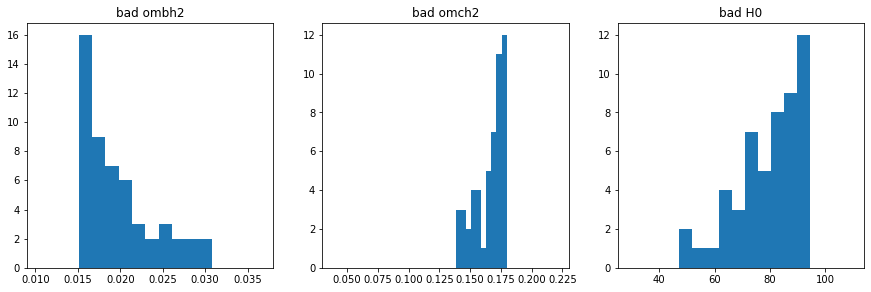

In [8]:
params_causing_spike = np.array(params_causing_spike)
fig, ax = plt.subplots(1,3, figsize=(15,4.5))
ax[0].hist(params_causing_spike[:, 0], bins = 10)
ax[0].set_title("bad ombh2")
ax[0].set_xlim(0.009, 0.038)
ax[1].hist(params_causing_spike[:, 1], bins = 10)
ax[1].set_title("bad omch2")
ax[1].set_xlim(0.03, 0.23)
ax[2].hist(params_causing_spike[:, 2], bins = 10)
ax[2].set_title("bad H0")
ax[2].set_xlim(25, 114)

In [9]:
best.genes

[0.0821673047,
 0.0353369396,
 5.04257456,
 0.468070264,
 1291.82108,
 0.4601042,
 1.30029558,
 -0.108872601,
 1.2773757,
 0.0216524787,
 0.0594868561,
 0.172557661,
 0.00373911112,
 0.552695616,
 -0.275902847,
 -0.213323894,
 -0.0312600935,
 16.342232,
 -0.00188705665,
 0.0513091978,
 1209.24328,
 -0.227283588]

In [10]:
# BEST-->>>> [ 4.45494962e-02,  9.92688526e-02,  1.62746999e+01,  4.53133654e-01, 1.20624809e+03,  5.40492643e-01,  1.86819618e-01,  8.47623143e-01, 1.53448389e+00,  1.22221556e-01,  1.00268977e-02,  9.31421132e-02, 1.17276709e-01, -3.05235699e-02,  3.29879050e+00,  4.09609621e-02, -5.92430773e-01,  7.70338361e-02,  5.64396553e-01,  1.38024169e+00, 1.41716096e+03, -6.95327175e+00]

In [11]:
# [2.53996139e-02,  1.06858394e-01,  2.15586829e+01,  4.12182991e-01, -4.62444492e+02, -1.96071827e-03, -1.52068985e+01, -2.85951428e-01, 1.23873843e+00,  5.59428848e-02,  2.85260069e-02, -5.84709194e-02, -1.16319078e-01,  2.17574784e-01, -1.89095882e+00,  1.87550750e-01, 1.11475579e-01,  6.46549102e-02, -6.81928867e-02,  1.01894837e+00, 1.44933988e+03, -2.00353225e+00]